In [2]:
try:
    import davos
except:
    %pip install davos
    import davos

davos.config.suppress_stdout = False

In [3]:
from matplotlib smuggle pyplot as plt                      # pip: matplotlib==3.6.2
smuggle matplotlib as mpl
from statannotations.Annotator smuggle Annotator           # pip: statannotations==0.6
smuggle statsmodels as sm                                  # pip: statsmodels==0.14.0

smuggle numpy as np                                        # pip: numpy==1.22.3
smuggle pandas as pd                                       # pip: pandas==1.5.1
smuggle seaborn as sns                                     # pip: seaborn==0.12.1
smuggle dill as pickle                                     # pip: dill==0.3.6
smuggle scipy as sp                                        # pip: scipy==1.10.0
smuggle sklearn as skl                                     # pip: scikit-learn==1.1.3

smuggle h5py                                               # pip: h5py==3.7.0
smuggle deepdish                                           # pip: deepdish==0.3.7
smuggle pathos                                             # pip: pathos==0.3.0
smuggle quail                                              # pip: quail==0.2.2
smuggle requests                                           # pip: requests==2.28.1
smuggle os
smuggle warnings
smuggle string
smuggle itertools
from copy smuggle deepcopy

from tqdm smuggle tqdm                                     # pip: tqdm==4.64.1
from matplotlib.ticker smuggle MaxNLocator
from pathos.multiprocessing smuggle ProcessingPool as Pool # pip: pathos==0.3.0
from multiprocessing smuggle cpu_count                     # pip: multiprocess==0.70.14
from sklearn.decomposition smuggle IncrementalPCA as PCA   # pip: scikit-learn==1.1.3

# local functions
from dataloader import datadir, grouping, feature_groupings, descriptions, sort_by_grouping, fetch_data
from analyze import analyze_data, recover_fingerprint_features, organize_by_listgroup, random, adaptive, non_adaptive_exclude_random, \
                    select_conds, select_lists, filter, get_diffs, stack_diffs, pnr_matrix, accuracy2df, adaptive_listnum2cond, \
                    clustering_matrices, average_by_cond, rename_features, fingerprint2temporal, get_boundaries, \
                    recall_accuracy_near_boundaries, results, results_by_list, analyses, listgroups, orders, \
                    create_clustering_df, compute_temporally_corrected_fingerprints, rename_dict, feature_dists, features, \
                    continuous_features, discrete_features
from plot import combo_lineplot, colors, plot_heatmaps, accuracy_by_list, fingerprint_scatterplot_by_category, combo_fingerprint_plot, \
                    plot_features, figdir, plot_trajectories, plot_accuracy_near_boundaries, plot_boundary_density_maps, barplot_helper

# Main text figures

For figure descriptions, see the [main text](https://psyarxiv.com/erzfp).

## Figure 3: Recall dynamics in feature rich free recall (order manipulation conditions)

Recall initiation

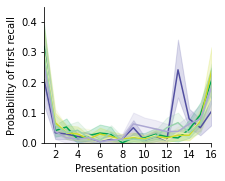

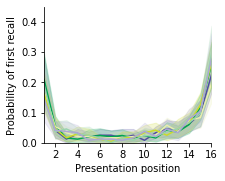

In [4]:
ylim = [0, 0.45]
combo_lineplot(results['pnr'][1], include_conds=non_adaptive_exclude_random, include_lists='Early', fname='pfr_early_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);
combo_lineplot(results['pnr'][1], include_conds=non_adaptive_exclude_random, include_lists='Late', fname='pfr_late_nonadaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);

Transitions

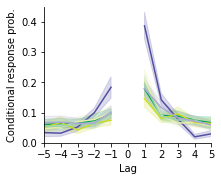

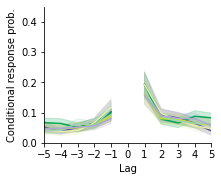

In [5]:
ylim = [0, 0.45]
combo_lineplot(results['lagcrp'], include_conds=non_adaptive_exclude_random, include_lists='Early', fname='crp_early_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);
combo_lineplot(results['lagcrp'], include_conds=non_adaptive_exclude_random, include_lists='Late', fname='crp_late_nonadaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);

Overall performance

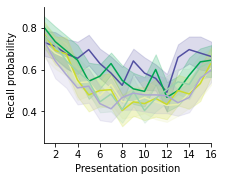

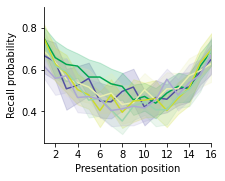

In [6]:
ylim = [0.25, 0.9]
combo_lineplot(results['spc'], include_conds=non_adaptive_exclude_random, include_lists='Early', fname='spc_early_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);
combo_lineplot(results['spc'], include_conds=non_adaptive_exclude_random, include_lists='Late', fname='spc_late_nonadaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);

Event boundaries

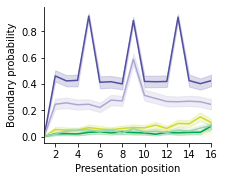

In [7]:
n_stddev = 2
boundaries, accuracy_near_boundaries = get_boundaries(n_stddev)

def plot_boundaries(boundaries, normalize=False):
    # use 1-indexing instead of 0-indexing for presentation position, per reviewer request
    for cond, f in boundaries.items():
        for fx, v in f.items():
            x = v.copy()
            x.columns = pd.RangeIndex(v.columns.start + 1, v.columns.stop + 1, v.columns.step)
            boundaries[cond][fx] = x

    fig = plt.figure(figsize=(3, 2.5))

    for cond in non_adaptive_exclude_random:
        df = boundaries[cond][cond].reset_index().melt(id_vars=['Subject', 'List'], var_name='Presentation position', value_name='Boundary probability')

        if normalize:  # z-score within list
            df['Boundary probability'] = df.groupby(['Subject', 'List'])['Boundary probability'].transform(lambda x: (x - x.mean()) / x.std())
        sns.lineplot(data=df, x='Presentation position', y='Boundary probability', color=colors[cond]);

    ax = plt.gca()
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)
    plt.xlim([1, 16])
    ax.set_xticks(range(2, 17, 2))

    return plt.gcf()

fig = plot_boundaries(boundaries)
plt.savefig(os.path.join(figdir, 'boundary_probabilities.pdf'), bbox_inches='tight')

Distances between adjacent items (normalize to have a max value of 1 for consistency across features)

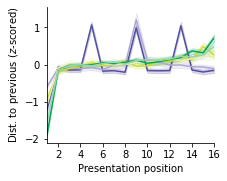

In [8]:
dists, _ = get_boundaries('unthresholded')

fig = plot_boundaries(dists, normalize=True)
plt.ylabel('Dist. to previous ($z$-scored)')
plt.savefig(os.path.join(figdir, 'adjacent_dists.pdf'), bbox_inches='tight')

## Figure 4: Memory "fingerprints" (order manipulation conditions)

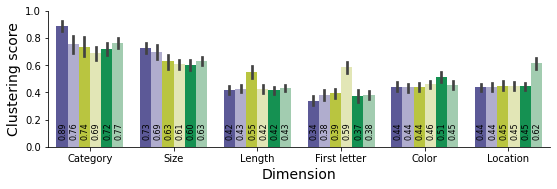

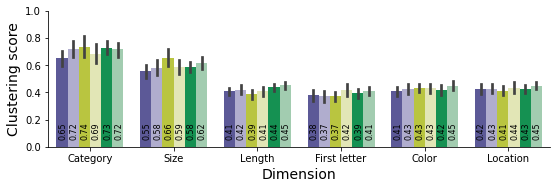

In [9]:
ylim = [0.0, 1.0]
combo_fingerprint_plot(results['fingerprint'], include_conds=non_adaptive_exclude_random, include_lists='Early', fname='fingerprint_early_nonadaptive', ylim= ylim, figsize=(9, 2.5));
combo_fingerprint_plot(results['fingerprint'], include_conds=non_adaptive_exclude_random, include_lists='Late', fname='fingerprint_late_nonadaptive', ylim=ylim, figsize=(9, 2.5));

## Figure 5: Recall probability and clustering scores on early and late lists

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Category_Early vs. Category_Late: t-test independent samples with Benjamini-Hochberg correction, P_val:5.040e-03 t=2.916e+00
Feature-rich_Early vs. Category_Early: t-test independent samples with Benjamini-Hochberg correction, P_val:3.112e-03 t=-3.034e+00
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Category_Early vs. Category_Late: t-test independent samples with Benjamini-Hochberg correction, P_val:2.472e-09 t=7.044e+00
Size_Early vs. Size_Late: t-test independent samples with Benjamini-Hochberg correction, P_val:8.317e-04 t=3.526e+00
Feature-rich_Early vs. Category_Early: t-test independent samples with Benjamini-Hochberg correction, P_val:5.679e-14 

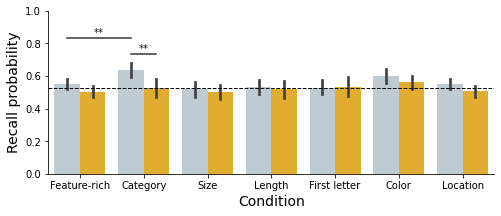

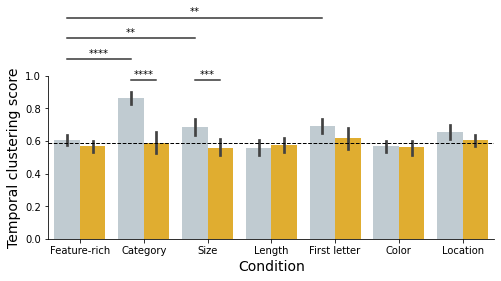

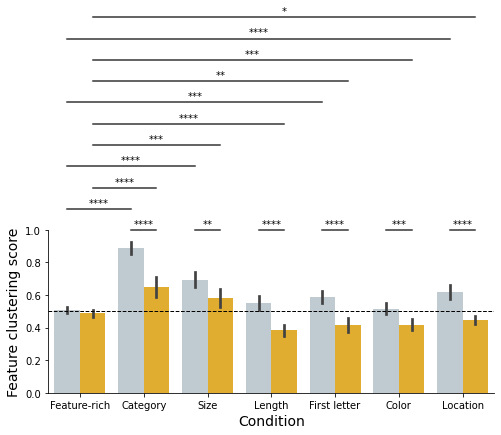

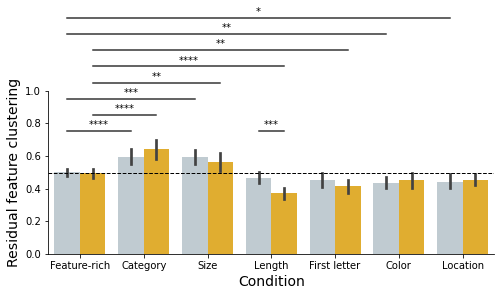

In [10]:
clustering_results = create_clustering_df(results)

barplot_helper(clustering_results, y='Recall probability', hue='List', palette=[colors['early'], colors['late']], width=8, height=3,
               ref='Feature-rich', fname='accuracy_by_cond_barplot', ylim=[0.0, 1.0]);
barplot_helper(clustering_results, y='Temporal clustering score', hue='List', palette=[colors['early'], colors['late']], width=8, height=3,
               ref='Feature-rich', fname='temporal_clustering_by_cond_barplot', ylim=[0.0, 1.0]);
barplot_helper(clustering_results, y='Feature clustering score', hue='List', palette=[colors['early'], colors['late']], width=8, height=3,
               ref='Feature-rich', fname='feature_clustering_by_cond_barplot', ylim=[0.0, 1.0]);
barplot_helper(clustering_results, y='Corrected feature clustering score', hue='List', palette=[colors['early'], colors['late']], width=8, height=3,
               ref='Feature-rich', fname='corrected_feature_clustering_by_cond_barplot', ylim=[0.0, 1.0], ylabel='Residual feature clustering');

## Figure 6: Memory fingerprint dynamics (order manipulation conditions)

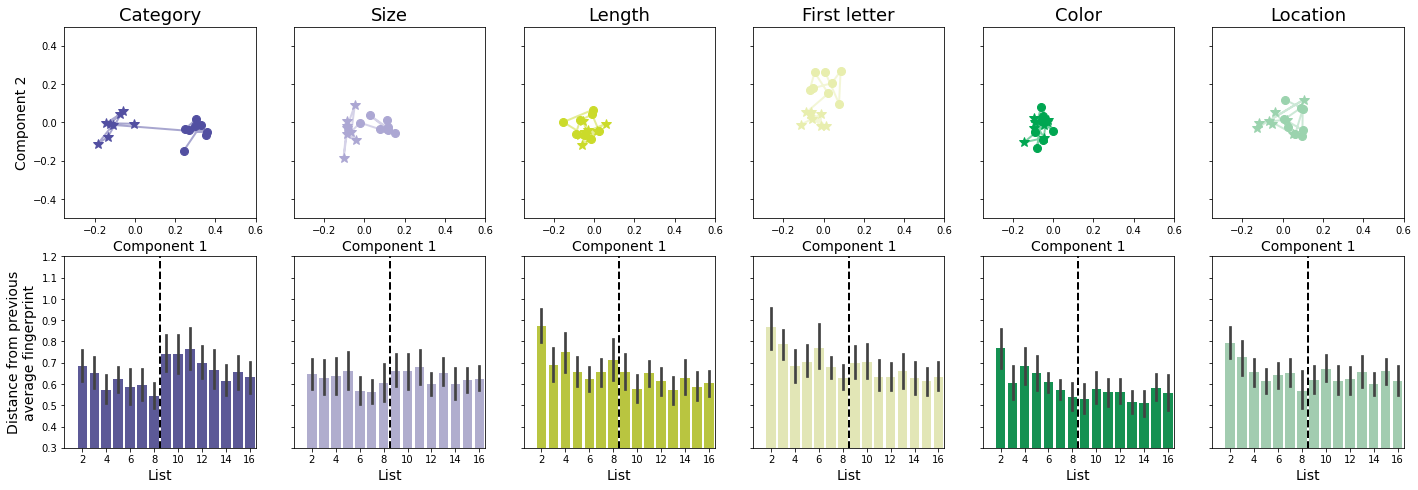

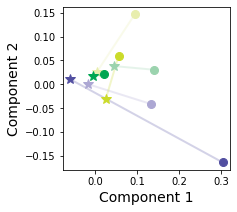

In [11]:
non_adaptive = sort_by_grouping([*random, *non_adaptive_exclude_random], feature_groupings)
average_early_fingerprints = average_by_cond(results['fingerprint'], include_conds=non_adaptive, include_lists='Early')
average_late_fingerprints = average_by_cond(results['fingerprint'], include_conds=non_adaptive, include_lists='Late')

pca = PCA(n_components=2)
pca.fit(pd.concat([average_early_fingerprints, average_late_fingerprints], axis=0));

early_fingerprints_lowD = pd.DataFrame(pca.transform(average_early_fingerprints), index=average_early_fingerprints.index)
late_fingerprints_lowD = pd.DataFrame(pca.transform(average_late_fingerprints), index=average_late_fingerprints.index)

xlim = [[-0.35, 0.6], [-0.5, 15.5]]
ylim = [[-0.5, 0.5], [0.3, 1.2]]

plot_trajectories(results_by_list['fingerprint'], include_conds=non_adaptive_exclude_random, fname='feature_clustering_trajectories_nonadaptive', xlim=xlim, ylim=ylim);
plot_features(early_fingerprints_lowD, late_fingerprints_lowD, non_adaptive_exclude_random, fname='clustering_pca_nonadaptive_nonrandom')

## Figure 7: Interactions between feature clustering, recall probability, and contiguity

Note: each panel and inset are generated separately

A

xlabel: Clustering score, ylabel: Recall probability


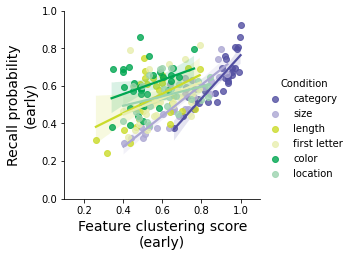

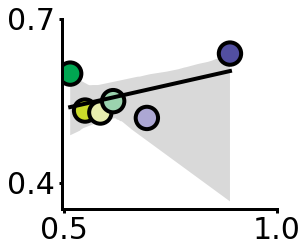

In [12]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', ylabel='Recall probability\n(early)', xlabel='Feature clustering score\n(early)', x='fingerprint', y='accuracy', fname='clustering_vs_accuracy_scatterplot_early', xlim=[0.1, 1.1], ylim=[0, 1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='accuracy', average=True, fname='ave_clustering_vs_accuracy_scatterplot_early');

B

xlabel: Clustering score, ylabel: Recall probability


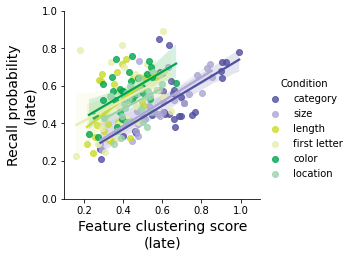

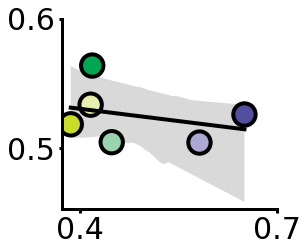

In [13]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', x='fingerprint', y='accuracy', xlabel='Feature clustering score\n(late)', ylabel='Recall probability\n(late)', fname='clustering_vs_accuracy_scatterplot_late', xlim=[0.1, 1.1], ylim=[0, 1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', x='fingerprint', y='accuracy', average=True, fname='ave_clustering_vs_accuracy_scatterplot_late');

C

xlabel: Clustering score (early), ylabel: Recall probability (late)


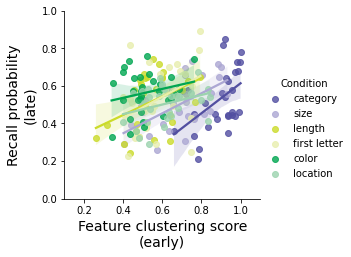

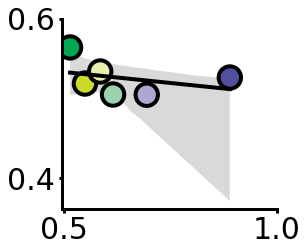

In [14]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Early', y_lists='Late', x='fingerprint', y='accuracy', fname='clustering_vs_accuracy_scatterplot_late_vs_early',
   xlabel='Feature clustering score\n(early)', ylabel='Recall probability\n(late)', xlim=[0.1, 1.1], ylim=[0, 1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Early', y_lists='Late', x='fingerprint', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_late_vs_early',
   xlabel='Clustering score (early)', ylabel='Recall probability (late)');

D

xlabel: Clustering score (late), ylabel: Recall probability (early)


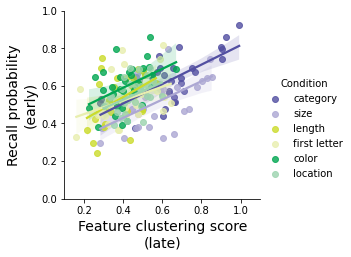

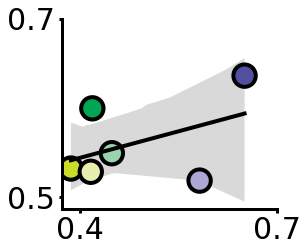

In [15]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='accuracy', fname='clustering_vs_accuracy_scatterplot_early_vs_late',
   xlabel='Feature clustering score\n(late)', ylabel='Recall probability\n(early)', xlim=[0.1, 1.1], ylim=[0, 1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_early_vs_late',
   xlabel='Clustering score (late)', ylabel='Recall probability (early)');

E

Note that there's a strange "bug" for this panel's inset: the inset's y-axis scale changes very slightly when you re-run the code.  The version used in the paper can be generated by running the code in the following cell twice.  (Both versions are "correct" and are identical other than having slightly different automatically generated y-limits for the inset plot.)

xlabel: Feature clustering score, ylabel: Temporal clustering score


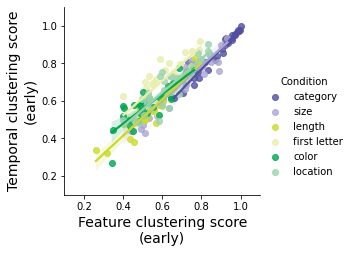

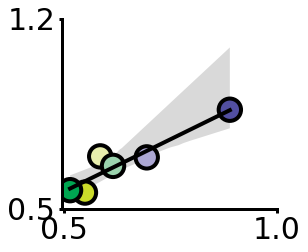

In [16]:
results['temporal'] = {c: fingerprint2temporal(f) for c, f in results['fingerprint'].items()}
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_early',
                                    xlim=[0.1, 1.1], ylim=[0.1, 1.1], ylabel='Temporal clustering score\n(early)', xlabel='Feature clustering score\n(early)');
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='temporal', average=True, fname='ave_clustering_vs_temporal_scatterplot_early',
                                    ylabel='Temporal clustering score', xlabel='Feature clustering score');                                                                                                    

F

xlabel: Feature clustering score, ylabel: Temporal clustering score


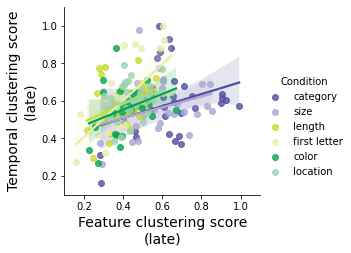

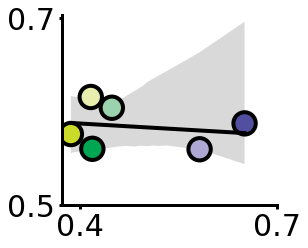

In [17]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_late',
                                    xlim=[0.1, 1.1], ylim=[0.1, 1.1], ylabel='Temporal clustering score\n(late)', xlabel='Feature clustering score\n(late)');
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, include_lists='Late', x='fingerprint', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_late',
                                    ylabel='Temporal clustering score', xlabel='Feature clustering score');

G

xlabel: Feature clustering score
(early), ylabel: Temporal clustering score
(late)


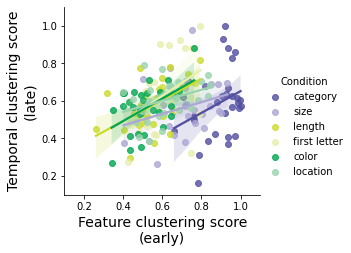

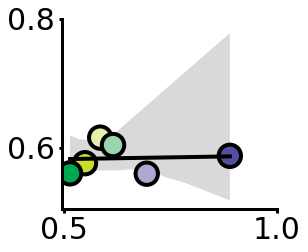

In [18]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Early', y_lists='Late', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_late_vs_early',
   xlabel='Feature clustering score\n(early)', ylabel='Temporal clustering score\n(late)', xlim=[0.1, 1.1], ylim=[0.1, 1.1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Early', y_lists='Late', x='fingerprint', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_late_vs_early',
   xlabel='Feature clustering score\n(early)', ylabel='Temporal clustering score\n(late)');

H

xlabel: Feature clustering score
(late), ylabel: Temporal clustering score
(early)


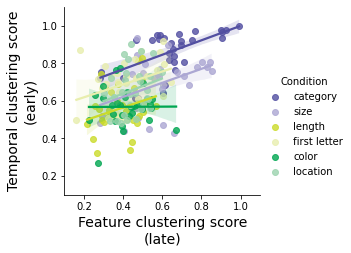

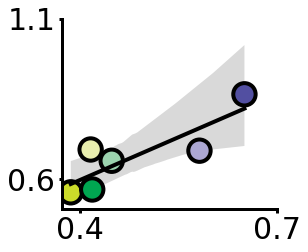

In [19]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_early_vs_late',
   xlabel='Feature clustering score\n(late)', ylabel='Temporal clustering score\n(early)', xlim=[0.1, 1.1], ylim=[0.1, 1.1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_early_vs_late',
   xlabel='Feature clustering score\n(late)', ylabel='Temporal clustering score\n(early)');

## Figure 8: Feature clustering carryover effects

Note: each panel and inset are generated separately

A

xlabel: Clustering score (late), ylabel: Clustering score (early)


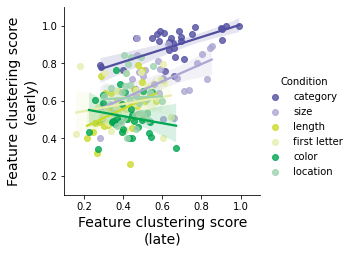

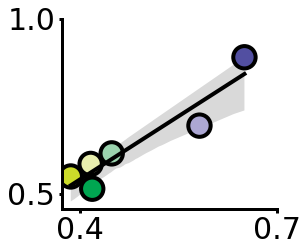

In [20]:
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='fingerprint', fname='feature_clustering_scatterplot_early_vs_late',
   ylabel='Feature clustering score\n(early)', xlabel='Feature clustering score\n(late)', xlim=[0.1, 1.1], ylim=[0.1, 1.1]);
fingerprint_scatterplot_by_category(results, include_conds=non_adaptive_exclude_random, x_lists='Late', y_lists='Early', x='fingerprint', y='fingerprint', average=True, fname='ave_feature_clustering_scatterplot_early_vs_late',
   ylabel='Clustering score (early)', xlabel='Clustering score (late)');

B

xlabel: Feature clustering score
(early - late), ylabel: Recall probability
(early - late)


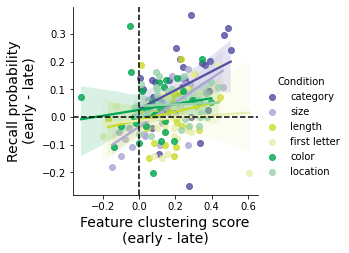

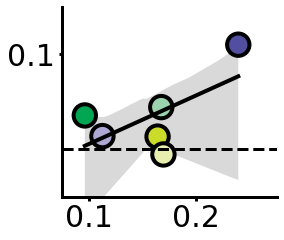

In [21]:
accuracy_diffs = get_diffs(results['accuracy'], contrast={'Early': 'Late'}, include_conds=non_adaptive_exclude_random)['Early - Late']
fingerprint_diffs = get_diffs(results['fingerprint'], contrast={'Early': 'Late'}, include_conds=non_adaptive_exclude_random)['Early - Late']

fingerprint_scatterplot_by_category({'accuracy': accuracy_diffs, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='accuracy', fname='clustering_vs_accuracy_scatterplot_diffs',
    xlabel='Feature clustering score\n(early - late)', ylabel='Recall probability\n(early - late)');
fingerprint_scatterplot_by_category({'accuracy': accuracy_diffs, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='accuracy', average=True,  fname='ave_clustering_vs_accuracy_scatterplot_diffs',
    xlabel='Feature clustering score\n(early - late)', ylabel='Recall probability\n(early - late)', ylim=[-0.05, 0.15], xlim=[0.075, 0.275]);   

C

xlabel: Feature clustering score
(early - late), ylabel: Temporal clustering score
(early - late)


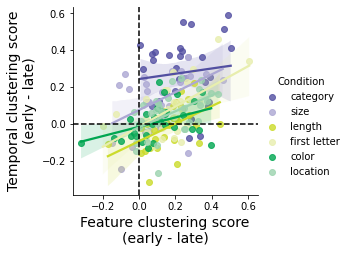

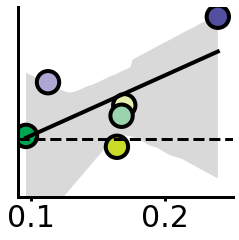

In [22]:
fingerprint_scatterplot_by_category({'temporal': {c: fingerprint2temporal(f) for c, f in fingerprint_diffs.items()}, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='temporal', fname='clustering_vs_temporal_scatterplot_diffs',
    xlabel='Feature clustering score\n(early - late)', ylabel='Temporal clustering score\n(early - late)');
fingerprint_scatterplot_by_category({'temporal': {c: fingerprint2temporal(f) for c, f in fingerprint_diffs.items()}, 'fingerprint': fingerprint_diffs},
    include_conds=non_adaptive_exclude_random, include_lists='Early', x='fingerprint', y='temporal', average=True,  fname='ave_clustering_vs_temporal_scatterplot_diffs',
    xlabel='Feature clustering score\n(early - late)', ylabel='Temporal clustering score\n(early - late)', xlim=[0.09, 0.25], ylim=[-0.13, 0.3]);

## Figure 9: Adaptive free recall

A

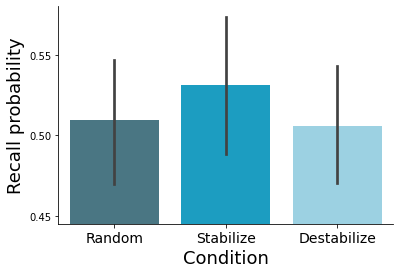

In [23]:
df = results['accuracy']['adaptive'].data.reset_index().melt(id_vars=['Subject', 'List'], value_name='Recall probability').rename({'List': 'Condition'}, axis=1).drop('variable', axis=1)
sns.barplot(data=df, x='Condition', y='Recall probability', palette=[colors['random'], colors['stabilize'], colors['destabilize']], order=['random', 'stabilize', 'destabilize'])
plt.ylim([0.445, 0.58])

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()], rotation=0, fontsize=14)
ax.set_yticks([0.45, 0.5, 0.55])

plt.ylabel('Recall probability', fontsize=18)
plt.xlabel('Condition', fontsize=18)

plt.savefig(os.path.join(figdir, 'accuracy_adaptive.pdf'), bbox_inches='tight')

B

/var/folders/tp/qtzc39jx5w556wl5w3dj21wr0000gn/T/ipykernel_2796/3238495754.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  df = results['fingerprint']['adaptive'].data.reset_index().melt(id_vars=['Subject', 'List'], value_name='temporal').rename({'List': 'Condition'}, axis=1).drop('variable', axis=1)


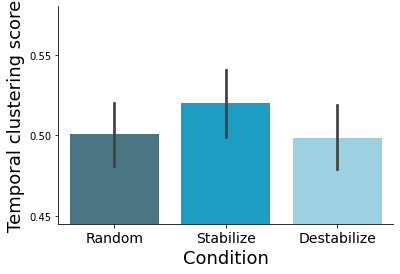

In [24]:
df = results['fingerprint']['adaptive'].data.reset_index().melt(id_vars=['Subject', 'List'], value_name='temporal').rename({'List': 'Condition'}, axis=1).drop('variable', axis=1)
sns.barplot(data=df, x='Condition', y='temporal', palette=[colors['random'], colors['stabilize'], colors['destabilize']], order=['random', 'stabilize', 'destabilize'])
plt.ylim([0.445, 0.58])

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.set_xticklabels([x.get_text().capitalize() for x in ax.get_xticklabels()], rotation=0, fontsize=14)
ax.set_yticks([0.45, 0.5, 0.55])

plt.ylabel('Temporal clustering score', fontsize=18)
plt.xlabel('Condition', fontsize=18)

plt.savefig(os.path.join(figdir, 'contiguity_adaptive.pdf'), bbox_inches='tight')

C

xlabel: Temporal clustering score, ylabel: Recall probability


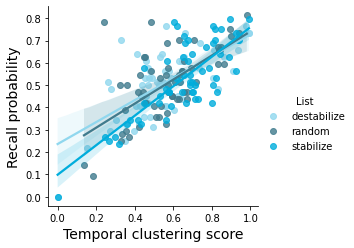

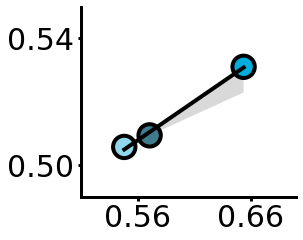

In [25]:
# create a single dataframe with the following columns:
#   - subject
#   - list type (random, stabilize, or destabilize)
#   - recall probability
#   - temporal clustering score

df = results['accuracy']['adaptive'].data.reset_index().query('List not in ["init"]').rename({0: 'Recall probability'}, axis=1)
df['Temporal clustering score'] = results['fingerprint']['adaptive'].data.reset_index().query('List not in ["init"]')['temporal']

sns.lmplot(data=df, x='Temporal clustering score', y='Recall probability', hue='List', palette=[colors[c] for c in ['destabilize', 'random', 'stabilize']], height=3.5, aspect=1.1)

ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

plt.xlabel(ax.get_xlabel(), fontsize=14)
plt.ylabel(ax.get_ylabel(), fontsize=14)

plt.savefig(os.path.join(figdir, 'scatterplot_accuracy_vs_contiguity_adaptive.pdf'), bbox_inches='tight')

fig = plt.figure(figsize=(1.1 * 3.5, 3.5))
sns.regplot(data=df.groupby('List').mean(), y='Recall probability', x='Temporal clustering score', color='k', marker='.', scatter_kws={'s': 0.1}, line_kws={'linewidth': 4})
sns.scatterplot(data=df.groupby('List').mean().reset_index(), y='Recall probability', x='Temporal clustering score', hue='List', palette=[colors[c] for c in ['destabilize', 'random', 'stabilize']], legend=False, s=500, edgecolor='k', linewidth=4)

# get rid of all tick labels except second and last, increase font size
ax = plt.gca()        
ax.set_xticks([np.round(ax.get_xticks()[1], decimals=2), np.round(ax.get_xticks()[-1], decimals=2)])
ax.set_yticks([np.round(ax.get_yticks()[1], decimals=2), np.round(ax.get_yticks()[-1], decimals=2)])
ax.tick_params(axis='both', which='major', labelsize=30)
plt.setp(ax.spines.values(), linewidth=3)
ax.xaxis.set_tick_params(width=3)
ax.yaxis.set_tick_params(width=3)

print('xlabel: {xlabel}, ylabel: {ylabel}'.format(xlabel=ax.get_xlabel(), ylabel=ax.get_ylabel()))
ax.set_xlabel('')
ax.set_ylabel('')

ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.xlim([0.51, 0.7])
plt.ylim([0.49, 0.55])

plt.savefig(os.path.join(figdir, 'average_scatterplot_accuracy_vs_contiguity_adaptive.pdf'), bbox_inches='tight')

D

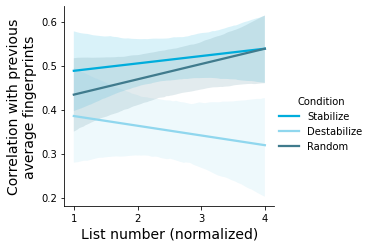

In [26]:
fingerprints = results_by_list['fingerprint']['adaptive'].data.reset_index()

# start by creating a dataframe just for the distances of the current list's fingerprint to the average of the previous lists
def get_corrs_to_average_previous(fingerprints):
    features = ['category', 'size', 'length', 'first_letter', 'color', 'pos']
    fingerprints = fingerprints[features]
    corrs = [0]
    for i in range(1, len(fingerprints)):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            corrs.append(np.corrcoef(fingerprints.iloc[i], fingerprints.iloc[:i].mean())[0, 1])
    return np.array(corrs)


fingerprint_corrs = {'stabilize': [], 'destabilize': [], 'random': []}
for subj in fingerprints.Subject.unique():
    x = fingerprints[fingerprints.Subject == subj].copy()
    x['Condition'] = listgroups['adaptive'][subj]
    x['Correlation with previous average'] = get_corrs_to_average_previous(x)
    for cond in fingerprint_corrs.keys():
        x_cond = x.query('Condition == @cond').copy()        
        x_cond['Normalized list number'] = x_cond['List'].apply(lambda x: x - x_cond['List'].min() + 1)
        fingerprint_corrs[cond].append(x_cond)

for cond in fingerprint_corrs.keys():
    fingerprint_corrs[cond] = pd.concat(fingerprint_corrs[cond], axis=0)

# combine dataframes
fingerprint_corrs = pd.concat(fingerprint_corrs.values(), axis=0)
fingerprint_corrs['Condition'] = fingerprint_corrs['Condition'].apply(lambda x: x.capitalize())

sns.lmplot(fingerprint_corrs, x='Normalized list number', y='Correlation with previous average', hue='Condition', palette=[colors[c.lower()] for c in fingerprint_corrs['Condition'].unique()], scatter=False, height=3.5, aspect=1.1)
ax = plt.gca()
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_xlabel('List number (normalized)', fontsize=14)
ax.set_ylabel('Correlation with previous\naverage fingerprints', fontsize=14)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.gcf().savefig(os.path.join(figdir, 'adaptive_fingerprint_corrs_by_list.pdf'), bbox_inches='tight')

# Supplemental figures

For figure descriptions, see the [supplemental materials](https://osf.io/j4xqk/).

## Figure S1: Recall dynamics in feature rich free recall (random conditions)

Recall initiation

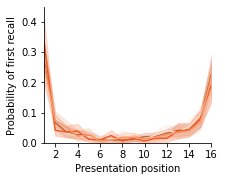

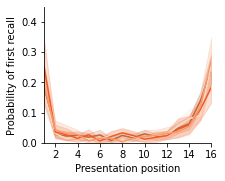

In [27]:
ylim = [0, 0.45]
combo_lineplot(results['pnr'][1], include_conds=random, include_lists='Early', fname='pfr_early_random', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);
combo_lineplot(results['pnr'][1], include_conds=random, include_lists='Late', fname='pfr_late_random', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);

Transitions

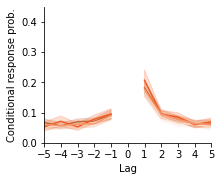

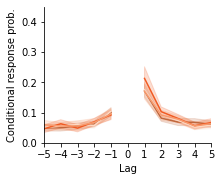

In [28]:
ylim = [0, 0.45]
combo_lineplot(results['lagcrp'], include_conds=random, include_lists='Early', fname='crp_early_random', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);
combo_lineplot(results['lagcrp'], include_conds=random, include_lists='Late', fname='crp_late_random', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);

Overall performance

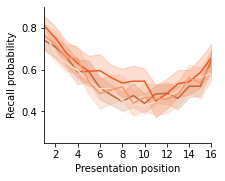

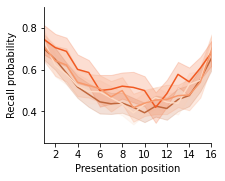

In [29]:
ylim = [0.25, 0.9]
combo_lineplot(results['spc'], include_conds=random, include_lists='Early', fname='spc_early_random', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);
combo_lineplot(results['spc'], include_conds=random, include_lists='Late', fname='spc_late_random', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);

## Figure S2: Recall dynamics in feature rich free recall (adaptive conditions)

Recall initiation

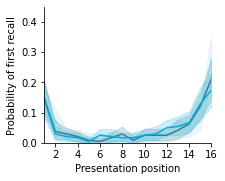

In [30]:
ylim = [0, 0.45]
combo_lineplot(results['pnr'][1], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='pfr_adaptive', xlabel='Presentation position', ylabel='Probability of first recall', ylim=ylim, xlim=[1, 16]);

Transitions

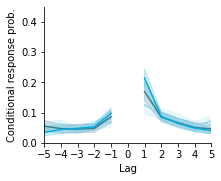

In [31]:
ylim = [0, 0.45]
combo_lineplot(results['lagcrp'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='crp_adaptive', xlabel='Lag', ylabel='Conditional response prob.', ylim=ylim);

Overall performance

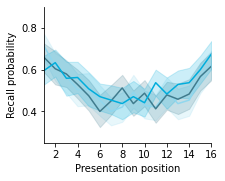

In [32]:
ylim = [0.25, 0.9]
combo_lineplot(results['spc'], include_conds='adaptive', include_lists=['destabilize', 'random', 'stabilize'], fname='spc_adaptive', xlabel='Presentation position', ylabel='Recall probability', ylim=ylim, xlim=[1, 16]);

## Figure S3: Recall accuracy by study list number

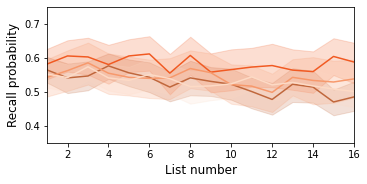

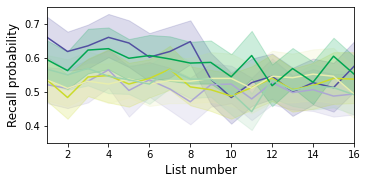

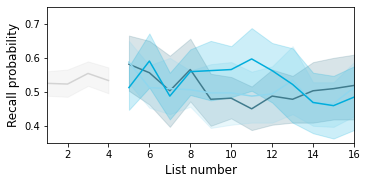

In [33]:
# non-adaptive conditions: organize by results key
random_accuracy = accuracy2df({c: results_by_list['accuracy'][c] for c in feature_groupings['random']})
nonadaptive_accuracy = accuracy2df({c: results_by_list['accuracy'][c] for c in non_adaptive_exclude_random})

# adaptive conditons: assign manually
adaptive_accuracy = results_by_list['accuracy']['adaptive'].data.reset_index().rename({0: 'Accuracy'}, axis=1)
adaptive_accuracy['Condition'] = adaptive_accuracy.apply(adaptive_listnum2cond, axis=1)

accuracy_by_list(random_accuracy, ylim=[0.35, 0.75], fname='random_accuracy_by_listnum');
accuracy_by_list(nonadaptive_accuracy, ylim=[0.35, 0.75], fname='nonadaptive_accuracy_by_listnum');
accuracy_by_list(adaptive_accuracy, ylim=[0.35, 0.75], fname='adaptive_accuracy_by_listnum');

## Figure S4: Correlations between feature clustering scores (order manipulation conditions)

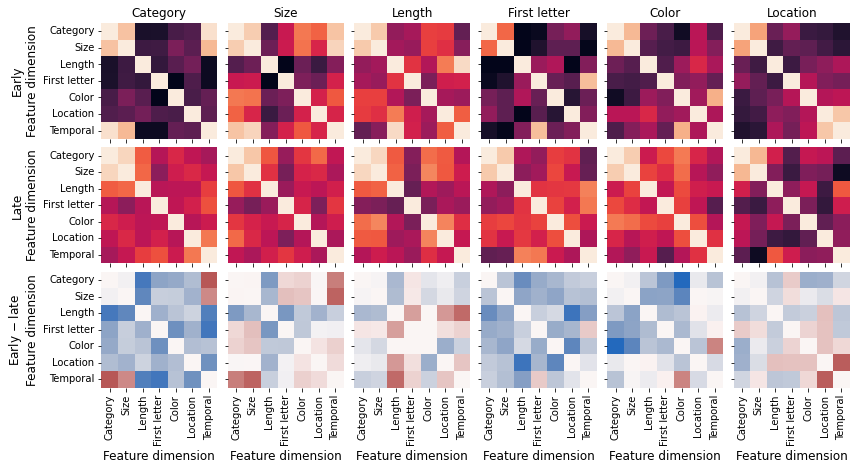

In [34]:
cluster_mats = clustering_matrices(results['fingerprint'], include_conds=non_adaptive_exclude_random, include_lists='all')
plot_heatmaps(cluster_mats, include_conds=non_adaptive_exclude_random, include_lists='all', contrasts={'Early': 'Late'}, fname='clustering_heatmaps_nonadaptive_nonrandom', vmin=-0.2, vmax=1.0, dvmin=-0.8, dvmax=0.8, fontsize=12, width=2, height=2.2, xlabel='Feature dimension', ylabel='Feature dimension');

In [35]:
def plot_colorbar(cmap):
    fig = plt.figure(figsize=(0.1, 2))
    ax = fig.add_subplot(111)
    norm = mpl.colors.Normalize(vmin=-1.0, vmax=1.0)
    mpl.colorbar.ColorbarBase(ax, cmap=cmap, norm=norm, orientation='vertical')
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True, right=True, top=True)
    plt.gcf().savefig(os.path.join(figdir, f'{cmap}_legend.pdf'), bbox_inches='tight')

In [36]:
plot_colorbar('rocket')

In [37]:
plot_colorbar('vlag')

## Figure S5: Memory "fingerprints" (random conditions)

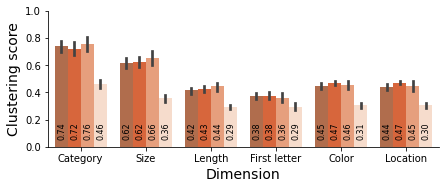

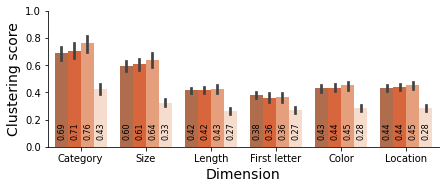

In [38]:
ylim = [0.0, 1.0]
combo_fingerprint_plot(results['fingerprint'], include_conds=random, include_lists='Early', fname='fingerprint_early_random', ylim= ylim, figsize=(7, 2.5));
combo_fingerprint_plot(results['fingerprint'], include_conds=random, include_lists='Late', fname='fingerprint_late_random', ylim=ylim, figsize=(7, 2.5));

## Figure S6: Memory "fingerprints" (adaptive conditions)

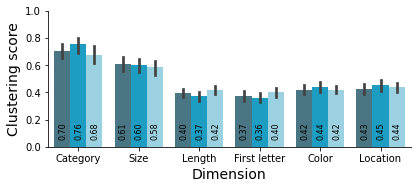

In [39]:
ylim = [0.0, 1.0]
combo_fingerprint_plot(results['fingerprint'], include_conds=['adaptive'], include_lists=['random', 'stabilize', 'destabilize'], fname='fingerprint_adaptive', ylim=ylim, figsize=(6.5, 2.5));

## Figure S7: Probability of $n^\mathrm{th}$ recall matrices

Weird bug: the x-tick rotations are inconsistent across different runs.  If the rotations are off, either re-run or play with the `rotx` argument.

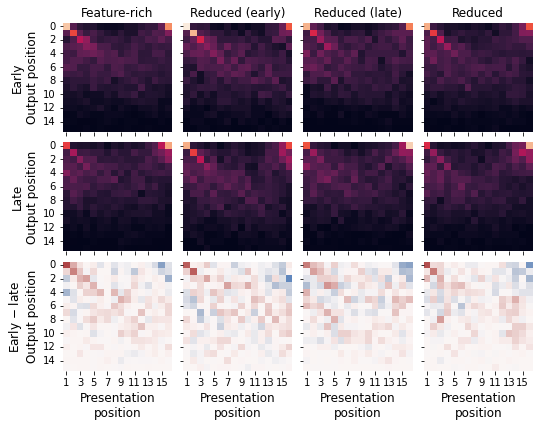

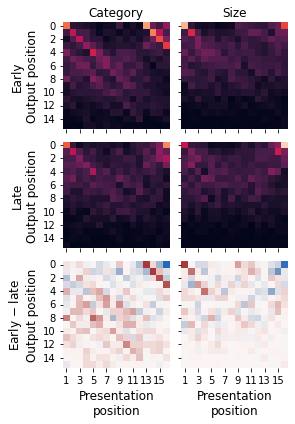

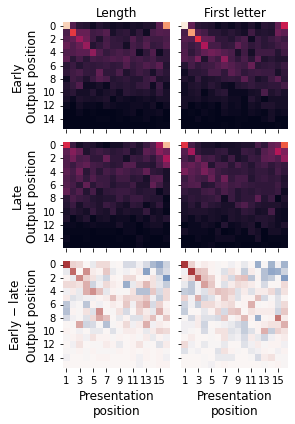

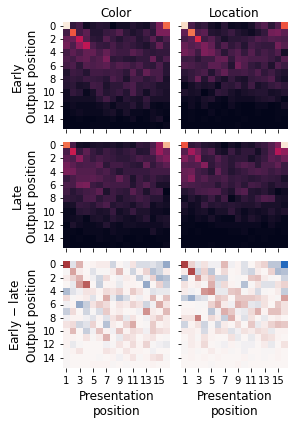

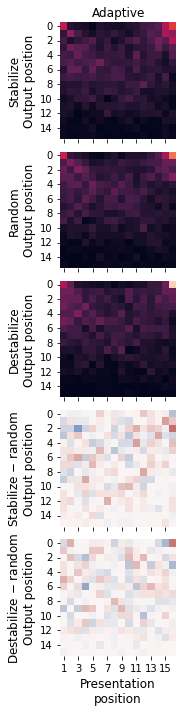

In [40]:
x = pnr_matrix(results['pnr'], include_conds='all')

# non-adaptive heatmaps
for group, conds in feature_groupings.items():
    if group == 'adaptive':
        continue
    
    if group == 'random':
        width = 1.9
        rotx = 0 # not sure why this is needed...
    else:
        width = 2.15
        rotx = 0
    plot_heatmaps(x, include_conds=conds, contrasts={'Early': 'Late'}, fname=f'pnr_heatmaps_{group}', vmin=0, vmax=0.3, dvmin=-0.1, dvmax=0.1, width=width, height=2, xlabel='Presentation\nposition', ylabel='Output position', rotx=rotx)

# adaptive heatmaps
plot_heatmaps(x, include_conds=['adaptive'], include_lists=['stabilize', 'random', 'destabilize'], contrasts={'stabilize': 'random', 'destabilize': 'random'}, fname='pnr_heatmaps_adaptive', vmin=0, vmax=0.3, dvmin=-0.1, dvmax=0.1, width=2.65, height=2, xlabel='Presentation\nposition', ylabel='Output position', rotx=0);

## Figure S8: Memory fingerprint dynamics (random conditions)

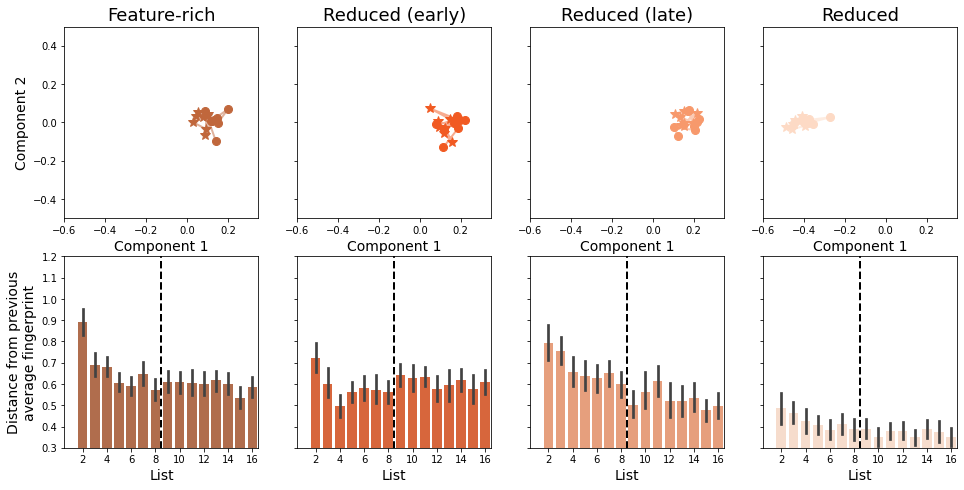

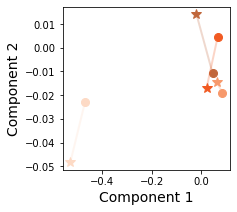

In [41]:
xlim = [[-0.6, 0.35], [-0.5, 15.5]]
ylim = [[-0.5, 0.5], [0.3, 1.2]]

plot_trajectories(results_by_list['fingerprint'], include_conds=random, fname='feature_clustering_trajectories_random', xlim=xlim, ylim=ylim);
plot_features(early_fingerprints_lowD, late_fingerprints_lowD, random, fname='clustering_pca_random')

# Figure S9: correlations between features

In [124]:
# for each column of feature_df, compute pairwise distances between all rows
# store the result in a new dataframe with the same column names

def dist_helper(data):
    x = pd.concat([pd.DataFrame.from_records([rename_dict(x) for x in r]) for _, r in
                   data.get_pres_features().iterrows()], axis=0, ignore_index=True).drop('temporal', axis=1)
    try:
        x['first letter'] = x['first letter'].apply(lambda x: string.ascii_uppercase.index(x))
    except TypeError:
        x['first letter'] = x['first letter'].apply(lambda x: string.ascii_uppercase.index(x.decode('utf-8')))

    def f(x):
        if type(x[0]) is list:
            vals = np.row_stack(x.values)
        elif np.char.isnumeric(str(x[0])):
            vals = np.atleast_2d(x.values).T
        else:
            vals = np.atleast_2d(x.values).T.astype(str)

            # convert to one-hot encoding
            enc = skl.preprocessing.OneHotEncoder()
            enc.fit(vals)
            vals = enc.transform(vals).toarray()

        return sp.spatial.distance.pdist(vals, metric='euclidean')
    
    return x.apply(f, axis=0)

In [129]:
correlation_savefile = os.path.join(datadir, 'scratch', 'feature_correlations.pkl')

if os.path.exists(correlation_savefile):
    with open(correlation_savefile, 'rb') as f:
        feature_correlations, columns = pickle.load(f)
else:
    data = fetch_data()
    all_dists = pd.concat([dist_helper(data[c]) for c in tqdm(data.keys())], axis=0)

    feature_correlations = sp.stats.spearmanr(all_dists, axis=0)
    columns = all_dists.columns

    with open(correlation_savefile, 'wb') as f:
        pickle.dump([feature_correlations, columns], f)

In [130]:
coefficients = pd.DataFrame(feature_correlations.statistic, index=columns, columns=columns)
pvalues = pd.DataFrame(feature_correlations.pvalue, index=columns, columns=columns)

feature_correlations = pd.DataFrame(np.zeros_like(coefficients), index=features,
                                    columns=features)

# store the correlation coefficients in the lower triangle, the p-values in the upper triangle, and
# remove the diagonal
for i, f1 in enumerate(features):
    for j, f2 in enumerate(features):
        if i == j:
            feature_correlations.loc[f1][f2] = np.nan
        feature_correlations.loc[f1][f2] = coefficients.loc[f1][f2]
        feature_correlations.loc[f2][f1] = np.round(pvalues[f2][f1], decimals=4)

feature_correlations.columns = feature_correlations.columns.str.capitalize()
feature_correlations.index = feature_correlations.index.str.capitalize()

In [133]:
feature_correlations

,Category,Size,Color,Location,Length,First letter
Category,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
Size,0.187893,0.000000,0.265900,0.719200,0.000000,0.0
Color,0.000475,-0.000043,0.000000,0.000000,0.025700,0.0
Location,0.000192,-0.000014,0.500772,0.000000,0.000000,0.0
Length,0.020729,0.001564,0.000086,-0.002156,0.000000,0.0
First letter,0.026560,0.006740,0.000207,-0.000886,0.016848,0.0


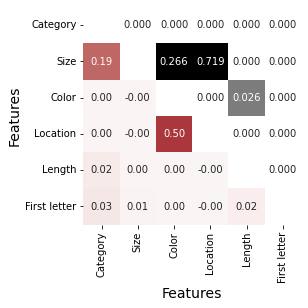

In [142]:
u_mask = np.triu(np.ones(feature_correlations.shape)).astype(bool)
l_mask = np.tril(np.ones(feature_correlations.shape)).astype(bool)

# color the lower-triangle by p-value using the Greens palette
# color the upper triangle by correlation coefficient using the vlag palette

ax = sns.heatmap(feature_correlations, mask=u_mask, cmap='vlag', square=True, center=0, annot=True, fmt='.2f', vmin=-0.1, vmax=0.25, cbar=False)
sns.heatmap(feature_correlations, mask=l_mask, cmap='gray_r', square=True, vmin=0, vmax=0.05, annot=True, fmt='.3f', ax=ax, cbar=False)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Features', fontsize=14);


plt.savefig(os.path.join(figdir, 'feature_correlations.pdf'), bbox_inches='tight')

In [140]:
plot_colorbar('gray_r')